# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf

## What's the standard deviation?

Here's a question that appeared [on Reddit](https://www.reddit.com/r/statistics/comments/hcvl2j/q_reverse_empirical_distribution_rule_question/) recently:

> I am trying to approximate a distribution based on the 68-95-99.7 rule--but in reverse. I would like to find an approximation for standard deviation, given:
> 
> Assumed normal dist.
> 
> Mean = 22.6
> 
> n = 100
> 
> 19 of n scored less than 10.0
> 
> Min = 0, Max = 37
> 
> My intuition tells me that it is possible to solve this problem but I don't think I learned how to do it in school and don't know the right words to use to look it up. Thanks for any assistance!!!

A user named efrique responded:

> You have 19% less than 10

> If the sample size were large enough (100 isn't very large, so this will have a fair bit of noise in it), you could just look at the 19th percentile of a normal. That's `-0.8779` standard deviations below the mean, implying `22.6-10 = 12.6` is 0.8779 of a standard deviation.

First, let's check his math.  I'll compute the 19th percentile of the standard normal distribution:

In [3]:
from scipy.stats import norm
norm.ppf(0.19)

-0.8778962950512288

So we expect the 19th percentile to be 0.8779 standard deviations below the mean.  In the data, the 19th percentile is 12.6 points below the mean, which suggests that the standard deviation is

In [4]:
sigma = 12.6 / 0.8779
sigma

14.352431939856475

Let's see what Bayes has to say about it.

If we knew that the standard deviation was 14, for example, we could compute the probability of a score less than or equal to 10:



In [5]:
sigma = 14
dist = norm(22.6, sigma)
ple10 = dist.cdf(10)
ple10

0.18406012534675947

Then we could use the binomial distribution to compute the probability that 19 out of 100 are less than or equal to 10.

In [6]:
from scipy.stats import binom

binom(100, ple10).pmf(19)

0.10005564608778429

But we don't know the standard deviation.  So I'll make up a range of possible values.

In [7]:
hypos = np.linspace(1, 41, 101)

Now we can compute the probability of a score less than or equal to 10 under each hypothesis.

In [8]:
ple10s = norm(22.6, hypos).cdf(10)
ple10s.shape

(101,)

And the probability that 19 out of 100 would be less than or equal to 10.

In [9]:
likelihood1 = binom(100, ple10s).pmf(19)
likelihood1.shape

(101,)

Here's what it looks like.

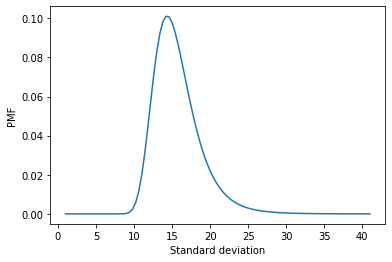

In [10]:
plt.plot(hypos, likelihood1)

plt.xlabel('Standard deviation')
plt.ylabel('PMF');

If we have no other information about sigma, we could use a uniform prior.

In [11]:
prior = Pmf(1, hypos)
posterior = prior * likelihood1
posterior.normalize()

1.6224932532278136

In that case the posterior looks just like the likelihood, except that the probabilities are normalized.

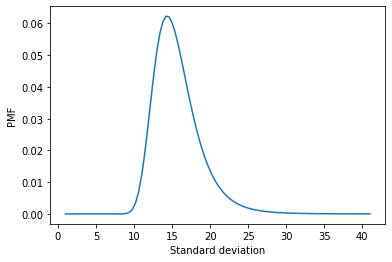

In [12]:
posterior.plot()
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

The most likely value in the posterior distribution is 14.2, which is consistent with the estimate we computed above.

In [13]:
posterior.max_prob()

14.200000000000001

The posterior mean is a little higher.

In [14]:
posterior.mean()

15.686820411746856

And the credible interval is pretty wide.

In [15]:
posterior.credible_interval(0.9)

array([11.8, 21.4])

## Using the maximum

However, we have left some information on the table.  We also know that the high score was 37.

If we knew sigma, we could compute the probability of a score less than or equal to 37.

In [16]:
sigma = 14
dist = norm(22.6, sigma)
ple37 = dist.cdf(37)
ple37

0.8481594451388403

And the probability density of a score exactly 37.

In [17]:
dens37 = dist.pdf(37)
dens37

0.016789938770944448

And combine them to get the likelihood that the max is 37:

In [18]:
ple37 ** 99 * dens37

1.3941897533280312e-09

We can do the same computation for the range of possible sigmas.

In [19]:
ple37s = norm(22.6, hypos).cdf(37)
dens37s = norm(22.6, hypos).pdf(37)

And compute the likelihood that the maximum score is 37.

In [20]:
likelihood2 = ple37s ** 99 * dens37s

Here's what it looks like.

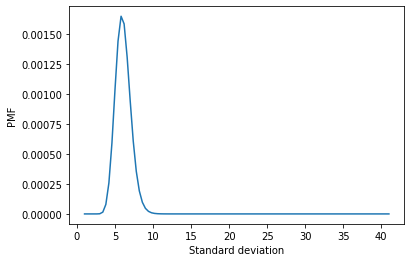

In [21]:
plt.plot(hypos, likelihood2)
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

Here's where we see a sign of trouble.  The fact that the maximum score is 37 suggests strongly that the standard deviation is less than 10.

That contradicts the conclusion, based on the 19th percentile, that the standard deviation is greater than 10.

In other words, under the assumptions of the model (particularly that the scores are normally distributed with known mean), the observed data are unlikely.

We can see how unlikely by computing the total probability of the data:

In [22]:
prior = Pmf(1, hypos)
prior.normalize()
posterior2 = prior * likelihood1 * likelihood2
posterior2.normalize()

1.4062315006783618e-09

It's pretty small.

And if we look at the posterior distribution, we see that the only remaining values are near 10.

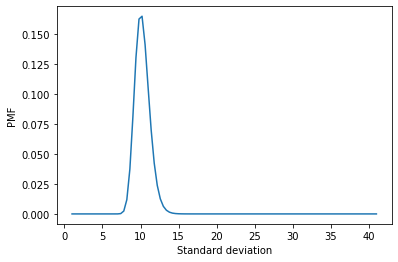

In [23]:
posterior2.plot()
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

However, we should not have much confidence in this.  The contradiction between the two pieces of evidence tells us that the model is problematic.

* If the 19th percentile is 10 and and mean is 22.6, the maximum score should be higher.  Or,

* If the maximum is 37 and the mean is 22.6, there should not be so many people below 10.

In summary:

* If we only use the 19th percentile, we estimate that the standard deviation is about 15, with 90% credible interval (11.8, 21.4).

* If we only use the maximum, we conclude that the standard deviation is about 6.

* The two pieces of evidence contradict each other, suggesting that the distribution of scores is not well modeled by the normal distribution.